In [1]:
import numpy as np
import pandas as pd
import scipy
import math
import random

import sklearn
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

This section explores the dataset file containing users reviews on various Amazon items (Reviews.csv).

In [2]:
reviews_df = pd.read_csv('./Data/Reviews.csv')
reviews_df.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
#we could read data from sql file instead

# import sqlite3
# cnx = sqlite3.connect('./Data/database.sqlite')
# df = pd.read_sql_query("SELECT * FROM Reviews", cnx)

In [4]:
total_count = len(reviews_df)
print('# of records (total): \t%d' % total_count)

# of records (total): 	568454


Fortunately not many missing values.

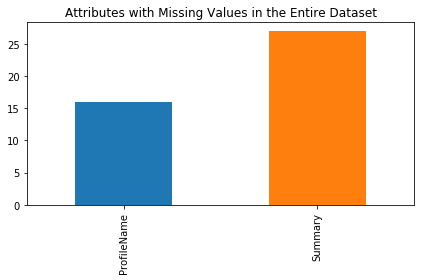

In [5]:
#count number of missing values in each type of attributes
def missing_count(df):
    msv = df.isnull().sum()
    msv = msv[msv > 0]
    msv.sort_values(inplace=True)
    return msv

missing = missing_count(reviews_df)

#plot attributes with missing values in the entire datset
plt.figure(figsize=[6,4])
missing.plot.bar()
plt.title('Attributes with Missing Values in the Entire Dataset')
plt.tight_layout()

In [6]:
from datetime import datetime
def to_datetime(ts):
    return datetime.fromtimestamp(ts)

def to_datetime_str(ts):
    return to_datetime(ts).strftime('%Y-%m-%d %H:%M:%S')

print('First review: \t%s' % to_datetime_str(reviews_df['Time'].min()))
print('Last review: \t%s' % to_datetime_str(reviews_df['Time'].max()))

First review: 	1999-10-07 17:00:00
Last review: 	2012-10-25 17:00:00


The dataset is not balanced as reviews are mostly have score of 5. 

In [7]:
temp_series = reviews_df['Score'].value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))

trace = go.Pie(labels=labels, values=sizes)
layout = go.Layout(
    title='Score distribution',
    width=600,
    height=600,
)
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="region")

In [8]:
color = sns.color_palette()
plt.rcParams['figure.figsize'] = [12, 6]
plt.style.use('seaborn-whitegrid')
matplotlib.rc('xtick', labelsize=11) 
matplotlib.rc('ytick', labelsize=11) 

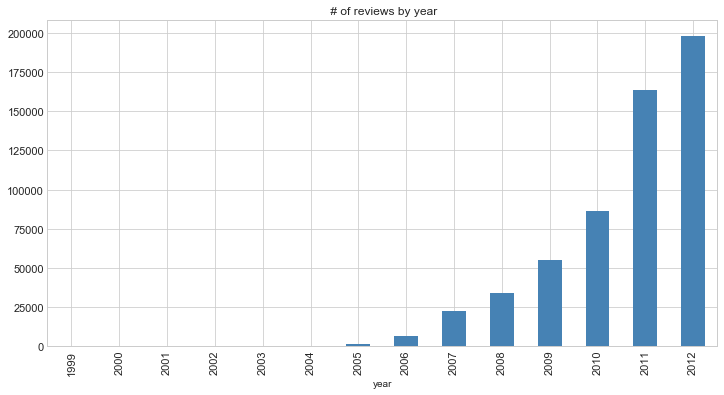

In [17]:
reviews_df['datetime'] = reviews_df['Time'].apply(lambda x: to_datetime(x))
reviews_df['year'] = reviews_df['datetime'].apply(lambda x: '{}'.format(x.year))
yearly_dist = reviews_df.groupby('year').size().plot(kind='bar', title=' # of reviews by year', color='steelblue')

We can ignore reviews before 2005.

In [10]:
reviews_df.groupby('year').size()

year
1999         6
2000        32
2001        13
2002        73
2003       133
2004       560
2005      1344
2006      6686
2007     22358
2008     34144
2009     55403
2010     86092
2011    163546
2012    198064
dtype: int64

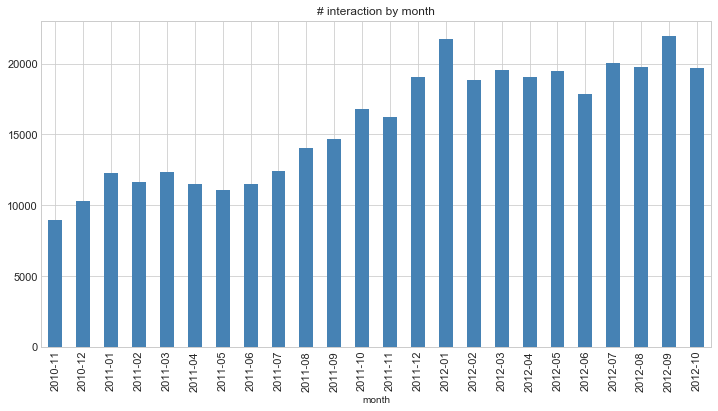

In [15]:
#monthly distribution of reviews for tje past 24 months
reviews_df['month'] = reviews_df['datetime'].apply(lambda x: '{0}-{1:02}'.format(x.year, x.month))
reviews_df.groupby('month').size()[-24:].plot(kind='bar', title='# interaction by month', color='steelblue')

In [12]:
print('Distinct products: \t%d' % len(reviews_df['ProductId'].unique()))
print('Distinct users: \t%d' % len(reviews_df['UserId'].unique()))
print('Distinct prfile names: \t%d' % len(reviews_df['ProfileName'].unique()))

Distinct products: 	74258
Distinct users: 	256059
Distinct prfile names: 	218417


The analysis of how many products a user has experience with is important for recommender systems. Higher number of reviewed products by users provides better modeling of users preference.
We can observe that 50% of the users have interacted with 1 product only, making this dataset not very suitable for collaborative filtering or content-based filtering methods unless we take a subset of data and keep users with at least a certain number of interactions.

In [13]:
reviews_df.groupby('UserId')['ProductId'].size().describe()

count    256059.000000
mean          2.220012
std           4.443361
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         448.000000
Name: ProductId, dtype: float64

Figure below shows the distribution of the number of user-product interactions.

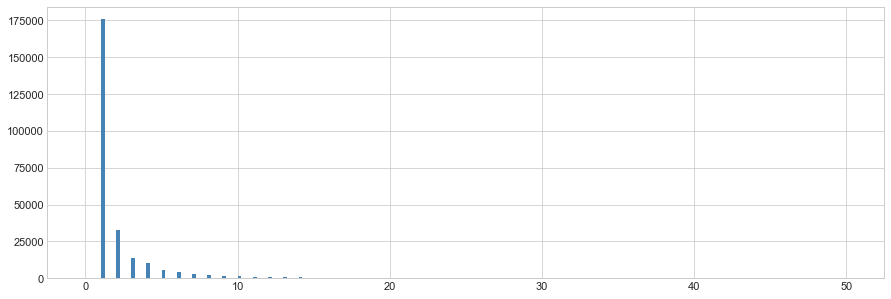

In [16]:
reviews_df.groupby('UserId')['ProductId'].size().hist(bins=200, figsize=(15,5), range=[0,50], color='steelblue')